## HackAI
Imports:

In [70]:
import datetime
import math
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import tensorflow as tf
sns.set()

In [71]:
df = pd.read_csv("../data/flights_searches.csv")
df.head()

,origin,destination,arrival_date,return_date,volume
0,BCN,ATH,2018-01-01,2018-01-01,9.0
1,BCN,ATH,2018-01-01,2018-01-02,6.0
2,BCN,ATH,2018-01-01,2018-01-03,3.0
3,BCN,ATH,2018-01-01,2018-01-04,6.0
4,BCN,ATH,2018-01-01,2018-01-05,4.0


In [72]:
df[["arrival_date", "return_date"]] = df[["arrival_date", "return_date"]].apply(pd.to_datetime)
df.head()

,origin,destination,arrival_date,return_date,volume
0,BCN,ATH,2018-01-01,2018-01-01,9.0
1,BCN,ATH,2018-01-01,2018-01-02,6.0
2,BCN,ATH,2018-01-01,2018-01-03,3.0
3,BCN,ATH,2018-01-01,2018-01-04,6.0
4,BCN,ATH,2018-01-01,2018-01-05,4.0


Sum the volume for each day

In [73]:
df = df.groupby(['origin', 'destination', 'arrival_date'], as_index=False).agg({'origin' : 'first', 'destination' : 'first',
                                                  'arrival_date': 'first', 'return_date': 'first',
                                                  'volume' : 'sum'})

In [74]:
df.head()
df.loc[df['volume'].idxmax()]


origin                          LON
destination                     NYC
arrival_date    2018-12-27 00:00:00
return_date     2018-12-27 00:00:00
volume                    1715017.0
Name: 62668, dtype: object

### Demand by day between 2 airports
The figure below shows the demand on each day between Barcelona and Athens airports

In [75]:

#bcn_to_ath = df.loc[(df['origin'] == "ROM") & (df['destination'] == "ATH") ]
bcn_to_ath = df.loc[(df['destination'] == "ATH") ]
bcn_to_ath['nth'] = np.arange(len(bcn_to_ath))

C:\Users\Liam\AppData\Local\Temp\ipykernel_12004\895813103.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bcn_to_ath['nth'] = np.arange(len(bcn_to_ath))


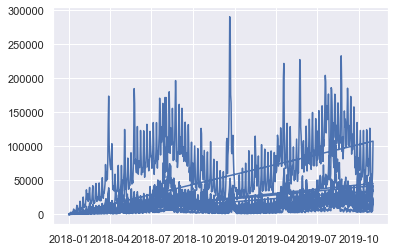

In [76]:
plt.figure()
x = bcn_to_ath['arrival_date']
y1 = bcn_to_ath['volume']
plt.plot(x, y1)


C:\Users\Liam\Documents\HackAI\venv\lib\site-packages\IPython\core\interactiveshell.py:3251: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


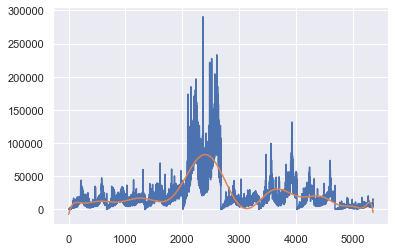

In [103]:
plt.figure()
x = bcn_to_ath['nth']
y1 = bcn_to_ath['volume']
plt.plot(x, y1)

polyModel = np.poly1d(np.polyfit([i for i in range(len(x))], y1, 20))
fitted_line = np.linspace(1, len(x), np.max(y1).astype(int))
plt.plot(fitted_line, polyModel(fitted_line))

In [104]:
"R-Squared: {}".format(r2_score(y1, polyModel(x)))

'R-Squared: 0.5204533525066812'

Predicting Values using the polynomial model

In [122]:
bcn_to_ath['anomaly'] = ((bcn_to_ath['volume'] - polyModel(bcn_to_ath['nth'])) > (2*polyModel(bcn_to_ath['nth'])))
anomalies = bcn_to_ath.loc[bcn_to_ath['anomaly']]
anomalies.loc[(anomalies.volume - polyModel(anomalies.nth)).sort_values(ascending=False).index]

C:\Users\Liam\AppData\Local\Temp\ipykernel_12004\209324677.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bcn_to_ath['anomaly'] = ((bcn_to_ath['volume'] - polyModel(bcn_to_ath['nth'])) > (2*polyModel(bcn_to_ath['nth'])))


,origin,destination,arrival_date,return_date,volume,nth,anomaly
52611,LON,ATH,2018-12-21,2018-12-21,290577.0,2364,True
52612,LON,ATH,2018-12-22,2018-12-22,282581.0,2365,True
52856,LON,ATH,2019-08-23,2019-08-23,233098.0,2609,True
52345,LON,ATH,2018-03-30,2018-03-30,173905.0,2098,True
87678,PAR,ATH,2019-08-03,2019-08-03,131747.0,3929,True
...,...,...,...,...,...,...,...
20,BCN,ATH,2018-01-21,2018-01-21,803.0,20,True
22,BCN,ATH,2018-01-23,2018-01-23,1132.0,22,True
24,BCN,ATH,2018-01-25,2018-01-25,1302.0,24,True
23,BCN,ATH,2018-01-24,2018-01-24,647.0,23,True


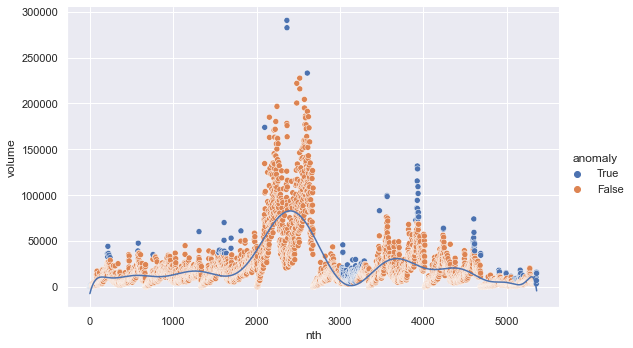

In [113]:
highlight = [True, False]
sns.relplot(data=bcn_to_ath, x='nth', y='volume', hue='anomaly', hue_order=highlight, aspect=1.61)
plt.plot(fitted_line, polyModel(fitted_line))

#bcn_to_ath.loc[(bcn_to_ath['nth'] == 4200) ]

In [88]:
bcn_to_ath['seven_rolling'] = bcn_to_ath.rolling(window=7).mean()
bcn_to_ath = bcn_to_ath.dropna()
bcn_to_ath.head()

C:\Users\Liam\AppData\Local\Temp\ipykernel_12004\2754209462.py:1: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['arrival_date', 'destination', 'origin', 'return_date'], dtype='object')
  bcn_to_ath['seven_rolling'] = bcn_to_ath.rolling(window=7).mean()


ValueError: Expected a 1D array, got an array with shape (5360, 3)

In [ ]:
plt.figure()
x = bcn_to_ath['arrival_date']
y1 = bcn_to_ath['seven_rolling']
plt.plot(x, y1)

In [ ]:
bcn_to_ath['volume_diff'] = bcn_to_ath['volume'].diff()
bcn_to_ath = bcn_to_ath.dropna()
bcn_to_ath.head()

## Learning the baseline
To identify the impact of a event, it is important to know the excess demand compared to the baseline demand.

How many uniquie routes are there?

In [123]:
len(df.drop_duplicates(['origin', 'destination']).index)

,origin,destination,arrival_date,return_date,volume
0,BCN,ATH,2018-01-01,2018-01-01,37.0
670,BCN,BER,2018-01-01,2018-01-01,112.0
1340,BCN,BKK,2018-01-01,2018-01-01,81.0
2010,BCN,BOM,2018-01-01,2018-01-02,3.0
2680,BCN,CUN,2018-01-01,2018-01-01,15.0
...,...,...,...,...,...
136005,VCE,SEA,2018-01-04,2018-01-05,13.0
136671,VCE,SFO,2018-01-01,2018-01-01,10.0
137341,VCE,SIN,2018-01-01,2018-01-01,3.0
138011,VCE,SYD,2018-01-01,2018-01-04,7.0


### Splitting into training and testing data
Because each route has its own unique patterns, a unique model will have to be constructed for each route.
The training set will use the first 70% of the days on each route and it will be tested on the subsequent 30% of values.

In [ ]:
#bcn_to_ath = bcn_to_ath[(np.abs(stats.zscore(bcn_to_ath[['volume']]) < 0.1)).all(axis=1)]
#bcn_to_ath.head()

In [ ]:
sc = MinMaxScaler(feature_range=(-1,1))
bcn_to_ath['volume_diff'] = sc.fit_transform(bcn_to_ath[['volume_diff']])

In [ ]:
plt.figure()
x = bcn_to_ath['arrival_date']
y1 = bcn_to_ath['volume_diff']
plt.plot(x, y1)

In [ ]:
"Number of entries from ROM to BER: {}, ".format(len(bcn_to_ath.index)) +\
"Training set size: {}, ".format(round(len(bcn_to_ath.index)*0.7)) +\
"Testing set size: {}".format(len(bcn_to_ath.index) - round(len(bcn_to_ath.index)*0.7))

In [ ]:
train_set, test_set = train_test_split(bcn_to_ath.sort_values(by='arrival_date'), test_size=0.3, shuffle=False)

In [ ]:
train = train_set[['volume_diff']].values
test = test_set[['volume_diff']].values

Inititalise an empty training and testing set
The model is given 20 consecutive values and has to predict the 21st

In [ ]:
lookback_length = 20
X_train = np.empty([train.shape[0]-lookback_length, lookback_length, 1])
Y_train = np.empty([train.shape[0]-lookback_length, 1])

X_test = np.empty([test.shape[0]-lookback_length, lookback_length, 1])
Y_test = np.empty([test.shape[0]-lookback_length, 1])
Y_train.shape

In [ ]:
for i in range(lookback_length, train.shape[0]):
  X_train[i-lookback_length] = train[i-lookback_length:i]
  Y_train[i-lookback_length] = train[i]

In [ ]:
for i in range(lookback_length, test.shape[0]):
  X_test[i-lookback_length] = test[i-lookback_length:i]
  Y_test[i-lookback_length] = test[i]

## Making the data stationary
To prevent the model learning specific volume values, the model is given the change in demand from the previous day.
Without this the model is susceptible to autocorrelation which it will ultimately become a persistence model.

In [ ]:
model = Sequential(
    [
        LSTM(units = lookback_length, return_sequences = True, input_shape = (lookback_length,1)),

        Dropout(0.2),

        LSTM(units=lookback_length, return_sequences=True),

        Dropout(0.2),

        LSTM(units=lookback_length, return_sequences=True),

        Dropout(0.2),

        LSTM(units=lookback_length),

        Dense(units=1)

    ]
)

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

In [ ]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [ ]:
model.fit(X_train, Y_train, epochs = 20, batch_size = 64, callbacks=[tensorboard_callback])

In [ ]:
test_MSE = model.evaluate(X_test, Y_test)

"TEST RMSE ::: " + str(math.sqrt(test_MSE))

In [ ]:
%tensorboard --logdir logs

In [ ]:
plt.figure(figsize=(15,11))
plt.title("Baseline predictions (delta)")
plt.plot(model.predict(X_test), label="Predicted")
#plt.plot(test[lookback_length:], label="Actual")
plt.ylabel('Share Value')
plt.xlabel('Day')
plt.legend(loc="lower left")


In [ ]:
plt.figure(figsize=(15,11))
plt.title("Baseline predictions (delta)")
#plt.plot(model.predict(X_test), label="Predicted")
plt.plot(test[lookback_length:], label="Actual")
plt.ylabel('Share Value')
plt.xlabel('Day')
plt.legend(loc="lower left")

## Actual Values

In [ ]:
seed_value = test_set['volume'].iloc[20]
seed_deltas = X_test[0]
model.predict(seed_deltas[None, ...])

In [ ]:
predictions = np.empty

def predictNext(volume, previous_values, n):
    if n <= 0:
        return volume
    delta = model.predict(previous_values[None, ...])
    delta = sc.inverse_transform(delta)
    print(delta)
    np.append(predictions, (volume + delta))
    return predictNext(volume + delta, np.append(previous_values[1:], delta), n-1)

In [ ]:
predictNext(seed_value, seed_deltas, 10)

In [ ]:
predictions